# Supervised Fine-Tuning Runnable Notebook 

Fine-tuning language models is essential for adapting to tasks, formats, new information, and environments.

This notebook presents a hands-on example where we enhance `Qwen/Qwen2.5-1.5B-Instruct` by teaching it to only produce JSON output when requested.


## Setup and Imports

First, let's import and configure everything that we need to run this notebook.

In [ ]:
!python3 -m pip install datasets transformers accelerate bitsandbytes huggingface_hub
!python3 -m pip install --force-reinstall --no-cache-dir -U "kubeflow @ git+https://github.com/opendatahub-io/kubeflow-sdk.git@v0.2.1+rhai0"
!python3 -m pip install --force-reinstall --no-cache-dir -U training-hub==0.4.0
!python3 -m pip install --force-reinstall --no-cache-dir -U ipykernel

## Demonstrating the JSON Output Problem

The `Qwen/Qwen2.5-1.5B-Instruct` model is a capable model despite its size, but it struggles with strict JSON output formatting. This is a common issue for agentic applications that need structured responses.

Let's test this directly with a table analysis task that requires pure JSON output.

For example, let's say we want to ask the model a question about the following table:

|Rank|Cyclist|Team|Time|UCI ProTour\nPoints|
|---|---|---|---|---|
|1|Alejandro Valverde (ESP)|Caisse d'Epargne|5h 29' 10"|40|
|2|Alexandr Kolobnev (RUS)|Team CSC Saxo Bank|s.t.|30|
|3|Davide Rebellin (ITA)|Gerolsteiner|s.t.|25|
|4|Paolo Bettini (ITA)|Quick Step|s.t.|20|
|5|Franco Pellizotti (ITA)|Liquigas|s.t.|15|
|6|Denis Menchov (RUS)|Rabobank|s.t.|11|
|7|Samuel Sánchez (ESP)|Euskaltel-Euskadi|s.t.|7|
|8|Stéphane Goubert (FRA)|Ag2r-La Mondiale|+ 2"|5|
|9|Haimar Zubeldia (ESP)|Euskaltel-Euskadi|+ 2"|3|
|10|David Moncoutié (FRA)|Cofidis|+ 2"|1|


And we want to know: which country had the most players appear in the top 10 list?

We can prompt the model like this:
```md
# Task Description: Please look at the table, and then answer the question. Return the final result as JSON in the format {"answer": "<YOUR ANSWER>"}.

## Input:
*Table*
which country had the most cyclists finish within the top 10?

Return the final result as JSON in the format {"answer": "<YOUR ANSWER>"}.
## Output:
```

Here are some responses we get from the vanilla `Qwen/Qwen2.5-1.5B-Instruct` (temp 0.6):

### Sample 1

```
{"answer": "No specific country had more than one cyclist finish within the top 10."}
```

### Sample 2

```
To determine which country had the most cyclists finish within the top 10, let's follow these steps:

1. Identify all cyclists from each team who finished in the top 10.
2. Count the number of cyclists per team.
3. Compare the counts to find the highest.

Step 1: Identifying top-10 cyclists:
- Alejandro Valverde (Spain)
- Alexandr Kolobnev (Russia)
- Davide Rebellin (Italy)
- Paolo Bettini (Italy)
- Franco Pellizotti (Italy)
- Denis Menchov (Russia)
- Samuel Sánchez (Spain)
- Stéphane Goubert (France)
- Haimar Zubeldia (Spain)

Step 2: Counting cyclists per team:
- Spain: 2 cyclists (Alejandro Valverde & David Moncoutié)
- Russia: 2 cyclists (Alexandr Kolobnev & Denis Menchov)
- Italy: 3 cyclists (Davide Rebellin, Paolo Bettini, Franco Pellizotti)
- France: 1 cyclist (Stéphane Goubert)

Step 3: Comparing counts:
The countries with the most cyclists finishing in the top 10 are Spain and Italy
```

### Sample 3
```
Here's the chain of reasoning followed by the answer:

1. First, we need to identify which countries have more than one cyclist finishing within the top 10.
   - Spain has two cyclists: Alejandro Valverde and Haimar Zubeldia
   - Russia has two cyclists: Denis Menchov and Samuel Sánchez

2. We can see that both Spain and Russia have more than one cyclist in the top 10.

3. To determine which country has "the most" cyclists, we compare their counts:
   - Spain: 2 cyclists
   - Russia: 2 cyclists

4. Since both countries tie with 2 cyclists, there isn't a clear winner based on this criterion alone.

Therefore, the correct answer is that both Spain and Russia tied for having the most cyclists finish within the top 10.

{"answer": "Spain and Russia"}
```


Although the model sometimes provided JSON as part of its output, our instruction explicitly requested the entire answer to be provided as JSON. These responses don't work consistently, since we would need to write fragile code in order to extract the answer we need if even produced -- a pattern we should avoid if possible. When an answer is produced.

## Understanding the Problem

As you can see from the output above, the vanilla Qwen model struggles with strict JSON formatting requirements. Even when explicitly instructed to respond with "ONLY valid JSON", it often:

- ❌ Adds explanatory text before or after the JSON
- ❌ Includes reasoning mixed with the JSON output  
- ❌ Sometimes doesn't follow the exact JSON schema requested

This makes it unreliable for agentic applications that need to parse structured responses programmatically.

> **Note:** Occasionally the model may respond with the correct format; however, this is a common behavior among LLMs. To be considered capable of JSON output, it must be able to **reliably** and **repeatably** respond with the requested format. 

## How SFT Will Solve This

We'll use SFT to teach Qwen to produce clean JSON outputs:

1. **Add new behavior**: Strict adherence to JSON output format when requested

Let's prepare the training data and run SFT training to fix this issue!


## Fine-tuning the model on TableGPT using SFT

Since prompting the model doesn't work, our next step is modifying the model.

## Dataset Preview: TableGPT

To fine-tune the model, we will be using the [Table-GPT](https://huggingface.co/datasets/LipengCS/Table-GPT) dataset from Microsoft.

This dataset provides us with thousands of high-quality samples which train a model to be given a table of data and provide an answer in a structured format such as JSON:


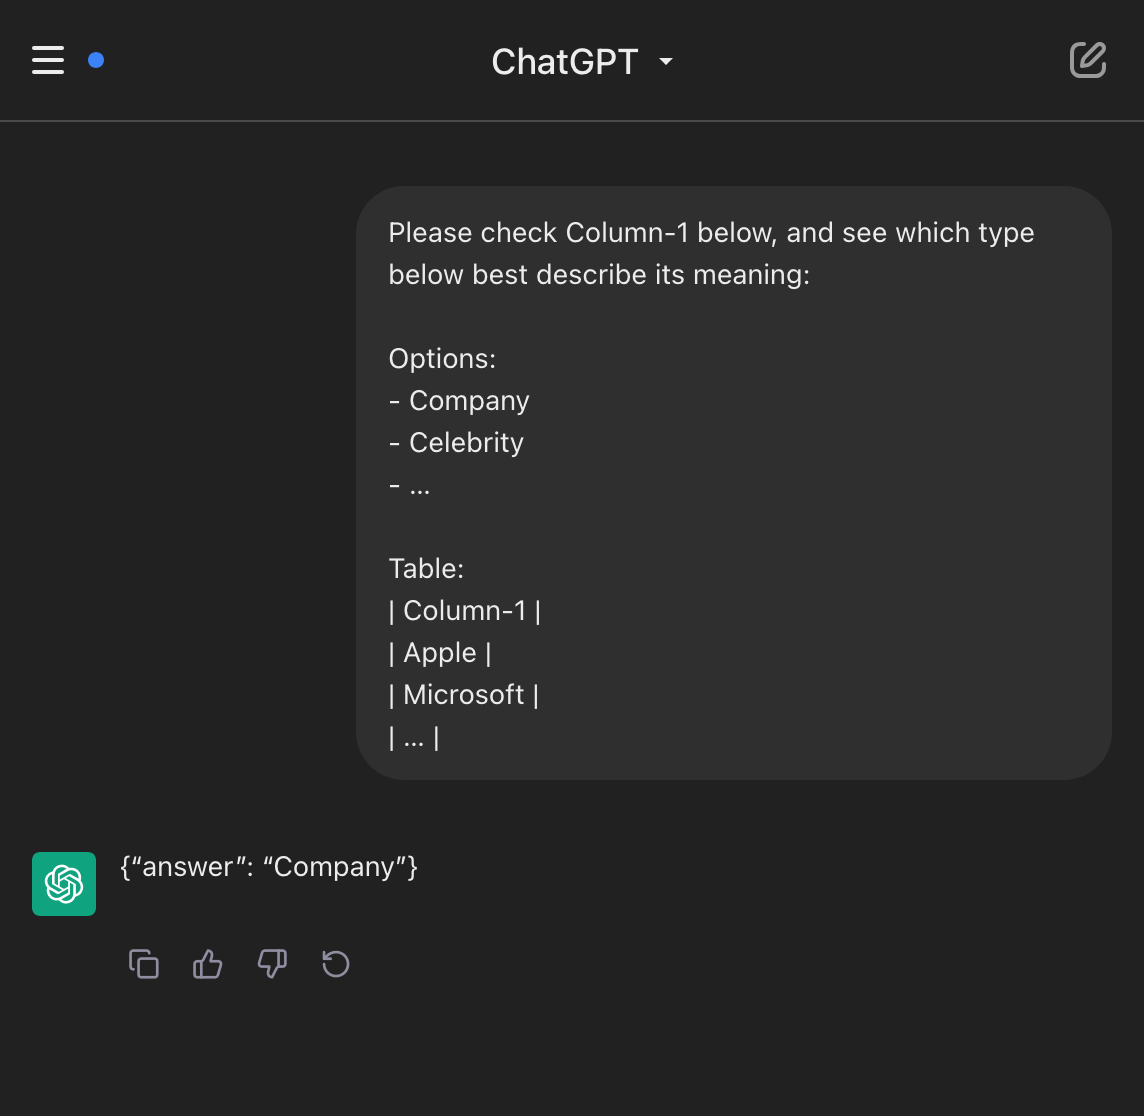

## Downloading the TableGPT dataset

To train the model using TableGPT, we need to have the dataset downloaded on our local machine first. We can do this with the `hf` CLI. 

In [ ]:
# Load dataset using Hugging Face datasets library
import json
import os
import random

from datasets import load_dataset

# Load the Table-GPT dataset
print("Loading Table-GPT dataset...")
dataset = load_dataset("LipengCS/Table-GPT", "All")

# Get the training split and create a random subset of 5000 samples
train_data = dataset["train"]
print(f"Original training set size: {len(train_data)}")

# Create a random subset of 5000 samples
random.seed(42)  # For reproducibility
subset_indices = random.sample(range(len(train_data)), min(5000, len(train_data)))
subset_data = train_data.select(subset_indices)

print(f"Subset size: {len(subset_data)}")

# Save the subset to a JSONL file

os.makedirs("/opt/app-root/src/shared/table-gpt-data/train", exist_ok=True)

with open(
    "/opt/app-root/src/shared/table-gpt-data/train/train_All_5000.jsonl", "w"
) as f:
    for example in subset_data:
        f.write(json.dumps(example) + "\n")

print(
    "Subset saved to /opt/app-root/src/shared/table-gpt-data/train/train_All_5000.jsonl"
)

## Downloading the Qwen2.5-1.5B model

We need to download a copy of the model to the shared storage directory in `/opt/app-root/src/shared/`. We can do this with the `hf` CLI. 

In [ ]:
import os

from huggingface_hub import snapshot_download
from huggingface_hub.utils import HfHubHTTPError, RepositoryNotFoundError


def download_model_snapshot(
    model_id: str,
    output_dir: str,
    revision: str = "main",
    token: str | bool | None = None,
    allow_patterns: list[str] | None = None,
    ignore_patterns: list[str] | None = None,
) -> str:
    """
    Downloads a model snapshot from the Hugging Face Hub using print statements.

    Args:
        model_id (str): The repository ID of the model (e.g., "meta-llama/Meta-Llama-3-8B").
        output_dir (str): The local directory to save the model files.
        revision (str): The model revision (branch, tag, or commit hash).
        token (str | bool | None): Hugging Face auth token.
            - If None (default): Uses HUGGINGFACE_HUB_TOKEN env var or login.
            - If True: Explicitly uses the stored token.
            - If str: Uses the provided token string.
        allow_patterns (list[str], optional): List of glob patterns to include.
        ignore_patterns (list[str], optional): List of glob patterns to exclude.

    Returns:
        str: The path to the downloaded snapshot directory.

    Raises:
        RepositoryNotFoundError: If the model is not found.
        HfHubHTTPError: For authentication errors (e.g., 401) or other HTTP issues.
        OSError: If the output directory cannot be created.
        Exception: For other unexpected errors.
    """
    print(f"Attempting to download repository: {model_id}")
    print(f"Target directory: {output_dir}")
    print(f"Revision: {revision}")

    # Ensure the output directory exists
    try:
        os.makedirs(output_dir, exist_ok=True)
    except OSError as e:
        print(f"Failed to create output directory {output_dir}: {e}")
        raise e  # Re-raise the exception

    # Handle token for gated/private models
    if token is None:
        token = os.getenv("HUGGINGFACE_HUB_TOKEN")
        if token:
            print(
                "Using HUGGINGFACE_HUB_TOKEN environment variable for authentication."
            )
        else:
            token = True  # Use locally cached token
            print("No explicit token. Will use locally cached token (if logged in).")

    try:
        # This is the core command.
        snapshot_path = snapshot_download(
            repo_id=model_id,
            local_dir=output_dir,
            revision=revision,
            token=token,
            allow_patterns=allow_patterns,
            ignore_patterns=ignore_patterns,
            resume_download=True,
            local_dir_use_symlinks=False,
        )

        print(f"✅ Successfully downloaded model to: {snapshot_path}")
        return snapshot_path

    except RepositoryNotFoundError as e:
        print(f"❌ Error: Repository '{model_id}' (revision: {revision}) not found.")
        print("Please check the model ID and revision name.")
        raise e

    except HfHubHTTPError as e:
        print(f"❌ HTTP Error: Failed to access {model_id}.")
        print(f"Status Code: {e.response.status_code}")
        if e.response.status_code == 401:
            print("This is an 'Unauthorized' error. The model may be private or gated.")
            print("Ensure you have accepted the license terms on the model's HF page.")
            print(
                "And that you are authenticated (use `huggingface-cli login` in your terminal)."
            )
        raise e

    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")
        raise e

In [ ]:
model_path = download_model_snapshot(
    model_id="Qwen/Qwen2.5-1.5B-Instruct",
    output_dir="/opt/app-root/src/shared/Qwen/Qwen2.5-1.5B-Instruct",
    token="",
)

## Authenticate to RHOAI

Before submitting our train job we need to make sure we are authenticated to our OpenShift cluster.

In [ ]:
# Standard library imports
import os
import time  # noqa
from io import StringIO  # noqa

from kubernetes import client as k8s

# Edit to match your specific settings
api_server = "<API_SERVER>"
token = "<API_TOKEN>"
PVC_NAME = "shared"  # Replace if the shared RWX storage name is different than in the example provided
PVC_PATH = "shared"  # Replace if the shared RWX storage path is different than in the example provided

configuration = k8s.Configuration()
configuration.host = api_server
# Un-comment if your cluster API server uses a self-signed certificate or an un-trusted CA
# configuration.verify_ssl = False
configuration.api_key = {"authorization": f"Bearer {token}"}
api_client = k8s.ApiClient(configuration)

## Configuration

For this example, we will be configuring for 4x80GB GPUs, but these hyperparameters can be adjusted for any machine; provided it is capable of running SFT. For more or less GPUs, adjust `nproc_per_node`, and based on total memory adjust the `max_tokens_per_gpu`. The shared volume mounted to this workbench instance will be mount on the training jobs on `/mnt/shared` so the following hyperparameters are adjusted based on that.

In [ ]:
training_parameters = {
    ################################################################################
    # 🤖 Model + Data Paths                                                        #
    ################################################################################
    "model_path": "/mnt/shared/Qwen/Qwen2.5-1.5B-Instruct",
    "data_path": "/mnt/shared/table-gpt-data/train/train_All_5000.jsonl",
    "ckpt_output_dir": "/mnt/shared/checkpoints",
    "data_output_dir": "/mnt/shared/traininghub-sft-data",  # for quicker multi-process loading of datasets set this to /dev/shm
    ################################################################################
    # 🏋️‍♀️ Training Hyperparameters                                                  #
    ################################################################################
    # Standard parameters
    "effective_batch_size": 128,
    "learning_rate": 5e-6,
    "num_epochs": 1,
    "lr_scheduler": "cosine",
    "warmpup_steps": 0,
    "seed": 42,
    ################################################################################
    # 🏎️ Performance Hyperparameters                                               #
    ################################################################################
    "max_tokens_per_gpu": 10000,
    "max_seq_len": 8192,
    ################################################################################
    # 💾 Checkpointing Settings                                                    #
    ################################################################################
    "checkpoint_at_epoch": True,
    "accelerate_full_state_at_epoch": False,
    ################################################################################
    # Resources
    ################################################################################
    "fsdp_options": {
        "sharding_strategy": "FULL_SHARD",
    },
    "nproc_per_node": 1,
    "nnodes": 2,
}


print("⚙️  Training Hyperparameters")
print("=" * 50)
print(json.dumps(training_parameters, indent=4))

## Define training client

We need to define our training client used to execute the training function

In [ ]:
import os

from kubeflow.common.types import KubernetesBackendConfig
from kubeflow.trainer import TrainerClient
from kubeflow.trainer.rhai import TrainingHubAlgorithms, TrainingHubTrainer

os.environ["CURL_CA_BUNDLE"] = ""
# Or specifically for the kubernetes library often used by the SDK:
os.environ["KUBERNETES_VERIFY_SSL"] = "False"
from kubernetes import config

# Load the in-cluster config which handles the local CA automatically
config.load_incluster_config()

backend_cfg = KubernetesBackendConfig(
    client_configuration=api_client.configuration,  # <— key part
)

client = TrainerClient(backend_cfg)
print(client)

## List Available Training Runtimes 

List the runtimes that are available on the cluster for training execution. Verify that a training-hub runtime exists and set it as the runtime for training.

In [ ]:
for runtime in client.list_runtimes():
    print("Found runtime: " + str(runtime))
    if runtime.name == "training-hub":
        th_runtime = runtime
        print("Found runtime: " + str(th_runtime))

## Training with SFT and Kubeflow Trainer

Define the TrainingHubTrainer and execute a train job with the client. This will result in a TrainJob CR created on the cluster and subsequent training pods. 
A shared volume is mounted to the training pods via the options params. This ensures that the dataset and model downloaded in this notebook is accessible to the training pods. 

In [ ]:
from kubeflow.trainer.options.kubernetes import (
    ContainerOverride,
    PodSpecOverride,
    PodTemplateOverride,
    PodTemplateOverrides,
)

cache_root = "/mnt/shared/huggingface"
triton_cache = "/mnt/shared/.triton"

job_name = client.train(
    trainer=TrainingHubTrainer(
        algorithm=TrainingHubAlgorithms.SFT,
        func_args=training_parameters,
        packages_to_install=[],
        env={
            "HF_HOME": cache_root,
            "TRITON_CACHE_DIR": triton_cache,
            "XDG_CACHE_HOME": "/opt/app-root/src/.cache",
            "NCCL_DEBUG": "INFO",
        },
        resources_per_node={
            "nvidia.com/gpu": 2,
            "memory": "64Gi",
            "cpu": 4,
        },
    ),
    options=[
        PodTemplateOverrides(
            PodTemplateOverride(
                target_jobs=["node"],
                spec=PodSpecOverride(
                    volumes=[
                        {
                            "name": "work",
                            "persistentVolumeClaim": {"claimName": PVC_NAME},
                        },
                    ],
                    containers=[
                        ContainerOverride(
                            name="node",  # Target the existing container
                            volume_mounts=[
                                {
                                    "name": "work",
                                    "mountPath": f"/mnt/{PVC_PATH}",
                                    "readOnly": False,
                                },
                            ],
                        )
                    ],
                ),
            )
        )
    ],
    runtime=th_runtime,
)

## Follow Job Logs

Let's fetch our job logs to make sure training is going as expected

In [ ]:
# Stream logs
for logline in client.get_job_logs(job_name, follow=True):
    print(logline, end="")

## Get Job Status

In [ ]:
# check job status
job = client.get_job(job_name)
print("Final TrainJob Status:")
print(f"   Name: {job.name}")
print(f"   Status: {job.status}")
print(f"   Created: {job.creation_timestamp}")
print(f"   Nodes: {job.num_nodes}")
print(f"   Runtime: {job.runtime.name}")

if job.steps:
    print("   Steps:")
    for step in job.steps:
        print(f"     - {step.name}: {step.status}")
    print()

## Check Training Progress 

In [ ]:
# from kubernetes import client as k8s

import json

from kubernetes import config

# config.load_incluster_config()
custom_api = k8s.CustomObjectsApi(api_client)

trainjob_name = job_name
# This needs to match the project name (namespace)
job_namespace = "training-hub-sft"

try:
    trainjob = custom_api.get_namespaced_custom_object(
        group="trainer.kubeflow.org",
        version="v1alpha1",
        namespace=job_namespace,
        plural="trainjobs",
        name=trainjob_name,
    )

    annotations = trainjob.get("metadata", {}).get("annotations", {})

    print(f"TrainJob Annotations for {trainjob_name}:\n")

    # Progression tracking config
    print("Config:")
    print(
        f"  tracking-enabled: {annotations.get('trainer.opendatahub.io/progression-tracking', 'N/A')}"
    )
    print(
        f"  metrics-port: {annotations.get('trainer.opendatahub.io/metrics-port', 'N/A')}"
    )
    print(
        f"  poll-interval: {annotations.get('trainer.opendatahub.io/metrics-poll-interval', 'N/A')}s"
    )

    # Progression metrics (if controller populated them)
    if "trainer.opendatahub.io/progress-percentage" in annotations:
        print("\nMetrics:")
        print(
            f"  progress: {annotations.get('trainer.opendatahub.io/progress-percentage', 'N/A')}%"
        )
        print(
            f"  step: {annotations.get('trainer.opendatahub.io/current-step', 'N/A')}/{annotations.get('trainer.opendatahub.io/total-steps', 'N/A')}"
        )
        print(
            f"  epoch: {annotations.get('trainer.opendatahub.io/current-epoch', 'N/A')}/{annotations.get('trainer.opendatahub.io/total-epochs', 'N/A')}"
        )
        print(
            f"  remaining: {annotations.get('trainer.opendatahub.io/estimated-remaining-seconds', 'N/A')}s"
        )
    print(f"\nAll annotations:\n{json.dumps(annotations, indent=2)}")

except Exception as e:
    print(f"Error: {e}")

## Testing our newly trained model
With the model trained, let's load it back in and evaluate it ourselves directly. Try sampling a few times to ensure format consistency was learned.

## Utility Functions
Let's define some helper functions for checkpoint management.

In [ ]:
import glob


# Let's define some helper functions for checkpoint management.
def find_most_recent_checkpoint(output_dir):
    """
    Find the most recent checkpoint in the training output directory.

    Args:
        output_dir (str): Training output directory containing hf_format/ subdirectory

    Returns:
        str: Path to the most recent checkpoint

    Raises:
        ValueError: If no checkpoints are found
    """
    # Get all checkpoint directories under hf_format
    checkpoint_pattern = os.path.join(output_dir, "hf_format", "samples_*")
    checkpoint_dirs = glob.glob(checkpoint_pattern)

    if not checkpoint_dirs:
        raise ValueError(
            f"No checkpoints found in {os.path.join(output_dir, 'hf_format')}"
        )

    # Find the most recently created checkpoint
    most_recent_checkpoint = max(checkpoint_dirs, key=os.path.getctime)

    return most_recent_checkpoint


print("✅ Checkpoint utility functions defined")

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

PVC_PATH = "shared"
CHECKPOINTS_PATH = f"{PVC_PATH}/checkpoints-logs-dir"
final_checkpoint = find_most_recent_checkpoint(CHECKPOINTS_PATH)

# Load the trained model and tokenizer
print("🔄 Loading the trained model...")
trained_tokenizer = AutoTokenizer.from_pretrained(
    final_checkpoint, trust_remote_code=True
)
trained_model = AutoModelForCausalLM.from_pretrained(
    final_checkpoint,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
    # Set to flash_attention_2 if flash attention v2 is available
    attn_implementation="sdpa",
    trust_remote_code=True,
)

print("✅ Model loaded successfully")
print(f"📊 Model parameters: {trained_model.num_parameters():,}")

# Test the model with a table reasoning task to evaluate its analytical capabilities
user_message = """# Task Description: Please look at the table, and then answer the question. Return the final result as JSON in the format {"answer": "<YOUR ANSWER>"}.

## Input:
*Table*
|Rank|Cyclist|Team|Time|UCI ProTour\nPoints|
|---|---|---|---|---|
|1|Alejandro Valverde (ESP)|Caisse d'Epargne|5h 29' 10"|40|
|2|Alexandr Kolobnev (RUS)|Team CSC Saxo Bank|s.t.|30|
|3|Davide Rebellin (ITA)|Gerolsteiner|s.t.|25|
|4|Paolo Bettini (ITA)|Quick Step|s.t.|20|
|5|Franco Pellizotti (ITA)|Liquigas|s.t.|15|
|6|Denis Menchov (RUS)|Rabobank|s.t.|11|
|7|Samuel Sánchez (ESP)|Euskaltel-Euskadi|s.t.|7|
|8|Stéphane Goubert (FRA)|Ag2r-La Mondiale|+ 2"|5|
|9|Haimar Zubeldia (ESP)|Euskaltel-Euskadi|+ 2"|3|
|10|David Moncoutié (FRA)|Cofidis|+ 2"|1|
*Question:*
which country had the most cyclists finish within the top 10?

Return the final result as JSON in the format {"answer": "<YOUR ANSWER>"}.
## Output:"""

# Format the message (adjust based on your model's chat template)
if hasattr(trained_tokenizer, "apply_chat_template"):
    messages = [{"role": "user", "content": user_message}]
    formatted_input = trained_tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
else:
    # Fallback formatting
    formatted_input = f"User: {user_message}\nAssistant:"

print("📊 Testing model with table reasoning task:")
print("Question: Which country had the most cyclists finish within the top 10?")
print("🤖 Model response:")

# Tokenize and generate
inputs = trained_tokenizer(formatted_input, return_tensors="pt").to(
    trained_model.device
)

with torch.no_grad():
    outputs = trained_model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.1,
        top_p=0.95,
    )

# Decode and print the response
response = trained_tokenizer.decode(outputs[0], skip_special_tokens=True)
# Remove the input part to show only the generated response
if formatted_input in response:
    response = response.replace(formatted_input, "").strip()

print(response)
print("\n✅ Table reasoning test completed!")

## Final Analysis and Summary
In this notebook, we demonstrated how Supervised Fine-Tuning (SFT) enables models to learn new tasks.

Using Qwen 2.5 1.5B Instruct, we were able to learn structured output consistency (for tool calling, agentic workflows, etc.)

## Cleanup
Cleanup the training job after completion

In [ ]:
client.delete_job(job_name)

In [ ]:
import gc

import torch

# Clear CUDA cache
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Collect garbage
gc.collect()

print("[CLEANUP] Torch resources freed, CUDA cache cleared.")